# **Assignment \#2**: Machine Learning MC886
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2020s2

**Group**:
- Bruno Benitez de Carvalho (167920)
- Eduardo Barros Innarelli (170161)

---

If you're using Google Colab, connect it with Google Drive to have access to the datasets:

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Go to the assignment directory (it depends on where it's saved in your Drive)
% cd '/content/drive/My Drive/[MC886] Assignments/Assignment 2'
! ls

/content/drive/My Drive/[MC886] Assignments/Assignment 2
2020s2-mc886-assignment-02.ipynb  fashion-mnist_train.csv
fashion-mnist_test.csv


---

## Objective 

Explore **classification techniques** (logistic regression & neural networks) and come up with the best possible model to the problem, avoiding overfitting. In particular, build an object recognition system to accurately classify images using the Fashion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist).

## Dataset

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.


Each training and test example is assigned to one of the following labels:

**Label 	Description**
- 0 	t-shirt/top
- 1 	trouser
- 2 	pullover
- 3 	dress
- 4 	coat
- 5 	sandal
- 6 	shirt
- 7 	sneaker
- 8 	bag
- 9 	ankle boot

**Dataset Information:**

- You should respect the following traininig/test split: 60,000 training examples, and 10,000 test examples. Avoid overfitting.
- The data is available at: https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip: 'train' folder (fashion-mnist_train.csv.zip) + 'test' folder (fashion-mnist_test.csv.zip)	
- Each row is a separate image. Column 1 is the class label. Remaining columns are pixel numbers (784 total). Each value is the darkness of the pixel (1 to 255). Dataset was converted to CSV with this script: https://pjreddie.com/projects/mnist-in-csv.


## Deadline

Monday, November 16th 7pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you did, your grade will be penalized as follows:
- November 17th 7pm : grade * 0.75
- November 18th 7pm : grade * 0.5
- November 19th 7pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**

---
## Dependencies

Here we import all packages used throughout this project.

In [ ]:
# For efficient array manipulation
import numpy as np

# For data analysis & manipulation
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For evaluating the predictions
from sklearn.metrics import confusion_matrix

# For training progress visualization
from tqdm import tqdm

## Pre-processing

Before doing anything, we need to load the training and test datasets.

In [ ]:
# Store labels
labels = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 
          'shirt', 'sneaker', 'bag', 'ankle boot']

# Load datasets
train_data = pd.read_csv("fashion-mnist_train.csv")
test_data = pd.read_csv("fashion-mnist_test.csv")

# Split features and labels
X, y = train_data.drop(['label'], axis = 1), train_data['label']
X_test, y_test = test_data.drop(['label'], axis = 1), test_data['label']

It's desirable to have balanced datasets, both for estimation and evaluation (accuracy works well with balanced datasets). As shown below, our data is perfectly balanced.

In [ ]:

print(f"Training labels:\n{y.value_counts()}\n")
print(f"Test labels:\n{y_test.value_counts()}")

Training labels:
9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

Test labels:
7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: label, dtype: int64


Let's take a look at some examples.

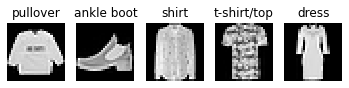

In [ ]:
for i in range(5):
  
  plt.subplot(1, 5, i+1)
  
  # Plot array as a 28 x 28 image
  plt.imshow(
      X.iloc[i].values.reshape(28, 28), cmap='gray', interpolation='none'
  )

  # Show class name and remove axis
  plt.title(labels[y[i]])
  plt.axis('off')

As for pre-processing, we'll just normalize the data by dividing all pixels by 255. This potentially accelerates the gradient descent, as explained in this answer at [quora.com](https://www.quora.com/Why-does-mean-normalization-help-in-gradient-descent):

> "Essentially, scaling the inputs (through mean normalization, or z-score) gives the error surface a more spherical shape, where it would otherwise be a very high curvature ellipse. Since gradient descent is curvature-ignorant, having an error surface with high curvature will mean that we take many steps which aren't necessarily in the optimal direction. When we scale the inputs, we reduce the curvature, which makes methods that ignore curvature (like gradient descent) work much better. When the error surface is circular (spherical), the gradient points right at the minimum, so learning is easy." - Daniel Hammack


In [ ]:
X, X_test = X / 255, X_test / 255

## Utils

Some common functions are shared by the models implemented in this work. The first one is a function that returns batches of the input, which helps to apply mini-batch gradient descent.

In [ ]:
def get_batches(df, batch_size):
  """
  Function that shuffles the data rows and split them into batches of size
  `batch_size`, returning an array of these batches. 
  """

  # Shuffle training data, if we want to split it
  shuffled = df.sample(frac=1) if len(df) > batch_size else df

  # Return splitted data
  return shuffled.groupby(np.arange(len(df))//batch_size)

To interpret the model outputs in a probabilistic manner we'll use the **softmax** function. To each one of the $C$ classes $i$ is associated a probability:

\begin{align}
p_{i} & = \frac{e^{z_i}}{\sum_{k=1}^C e^{z_k}} \\
\end{align}

This function can be numerically unstable with large exponents. To prevent overflow, a normalized version that shifts all the exponents to negative is implemented.

In [ ]:
def stable_softmax(X):
  """
  Numerically stable softmax function.
  """
  
  exps = np.exp(X - np.max(X))
  return exps / np.sum(exps, axis=1, keepdims=True)

**Cross entropy** is a widely used measure to compute the distance between the hypothesis and the expected output when the hypothesis is a probability distribution, which is the case. It is defined as:

\begin{align}
J(y,p) & = - \sum_{k=1}^C y_i \log(p_i) \\
\end{align}

Where $y$ is a one hot encoded vector for the labels. A helpful characteristic of this function is that it's partial derivative in relation to a pre-softmax output $z_i$ is very simple:

\begin{align}
\frac{\partial J}{\partial z_i} & = p_i - y_i \\
\end{align}

To see a detailed development of these equations, [click here](https://deepnotes.io/softmax-crossentropy).

**Obs**: $y$ is not one hot encoded in the implementation, but the cross entropy and it's derivative can still be calculated in a vectorized manner.


In [ ]:
def cross_entropy_loss(X, y):
  """
  Cross entropy loss function. Returns the probability associated with each
  class and the loss.
  """

  m = y.shape[0]
  p = stable_softmax(X) # probabilities
  log_likelihood = -np.log(p[range(m), y]) # J
  loss = np.sum(log_likelihood) / m # average accross samples
  return p, loss

def cross_entropy_derivative(y, p):
  """
  Cross entropy derivative. Returns the gradient array.
  """

  m = y.shape[0]
  dloss = p # initialize
  dloss[range(m), y] -= 1 # p_i - y_i
  dloss /= m # average accross samples
  return dloss

It's also useful to specify some plot functions, as we want to graphically evaluate the training process.

In [ ]:
def plot_cost_history(train_history):
  '''
  Function that plots the training cost per iteration curve.
  '''

  iterations = range(1, len(train_history) + 1) 
  plt.plot(iterations, train_history, 'b-')
  plt.title('Training Cost')
  plt.legend(['Training Acc'])
  plt.xlabel('Iteration')
  plt.ylabel('Cost')
  plt.show()

def plot_acc_history(train_history, val_history):
  '''
  Function that plots the training and validation acc per iteration curves side
  by side. 
  '''

  iterations = range(1, len(train_history) + 1) 
  plt.plot(iterations, train_history, 'r--')
  plt.plot(iterations, val_history, 'b-')
  plt.title('Training and Validation Accuracy')
  plt.legend(['Training Acc', 'Validation Acc'])
  plt.xlabel('Iteration')
  plt.ylabel('Accuracy')
  plt.show()

**Note**: the part of the text relative to what Sandra asked in the assignment is quoted and highlighted.

## **Activity 1**: Softmax Regression (2 points)

> **Perform Multinomial Logistic Regression (_i.e._, softmax regression). It is a generalization of Logistic Regression to the case where we want to handle multiple classes. You should implement your solution.**

In this activity we can simply adapt the gradient descent method for Linear Regression implemented at [project 1](https://colab.research.google.com/drive/1BQbm6EtJ_m2WebQuM-_AcLo-bMoy1hxL?usp=sharing). The difference now is that the hypothesis and the cost function will respectively be the softmax and the cross entropy functions, described at the last section. 

Before writing the regression algorithm, we define a function that takes an input and the model parameters and make predictions, which will be used for evaluating the accuracy during the gradient descent.

In [ ]:
def predict(X, theta, bias):
  """
  Predicts in which class each sample in X is for given parameters and bias.
  """

  p = stable_softmax(np.dot(X, theta) + bias)
  return np.argmax(p, axis=1)

The softmax regression method is defined below. Notice that we split the dataset into two at the beginning, one for training with $\frac{2}{3}$ of the examples and other for validation with $\frac{1}{3}$. By the chain rule, the gradient is computed as the dot product between the input and the cross entropy derivative.

In [ ]:
def softmax_regression(X, y, k, lr=1e-2, n_epochs=100, batch_size=100):
  """
  Gradient descent method that updates the parameters of a model for a 
  multinomial logistic regression problem with a Cross Entropy cost function, 
  returning a tuple with the fitted parameters and all epochs training costs 
  and training + validation accuracies.
  """

  n_images = X.shape[0]
  n_pixels = X.shape[1]

  train_history = {'acc': [], 'loss': []}
  val_history = {'acc': []}

  # Split training and validation set
  X_train, X_val = np.split(X, [int((2/3) * len(X))])
  y_train, y_val = np.split(y, [int((2/3) * len(y))])

  # Initialize theta (parameters) randomly and bias with zeros
  theta = np.random.randn(n_pixels, k)
  bias = np.zeros((1, k)) 

  pbar = tqdm(range(n_epochs), position=0, unit='epoch')
  for epoch in pbar:

    # We shuffle X_train and y_train concatenated, to generate stable batches
    concat_data = pd.concat([X_train, y_train], axis=1)
    batches = get_batches(concat_data, batch_size)

    for (_, batch) in batches:

      # Detach X_train and y_train portions from batch
      X_batch = batch.drop(columns='label').values 
      y_batch = batch['label'].values

      # Output (pre-softmax)
      z = np.dot(X_batch, theta) + bias

      # Probabilities and cost
      p, loss = cross_entropy_loss(z, y_batch)

      # Compute gradients
      dloss_z = cross_entropy_derivative(y_batch, p)
      dtheta = np.dot(X_batch.T, dloss_z)
      dbias = np.sum(dloss_z, axis=0, keepdims=True)

      # Atualize parameters
      theta -= lr * dtheta
      bias -= lr * dbias

    # Calculate training and validation accuracies
    train_acc = (predict(X_train, theta, bias) == y_train).mean()
    val_acc = (predict(X_val, theta, bias) == y_val).mean()

    # Store loss and accuracies for future evaluation
    train_history['loss'].append(loss)
    train_history['acc'].append(train_acc)
    val_history['acc'].append(val_acc)

    # Show loss and accuracies at the progress bar
    pbar.set_postfix({
        'train_loss': round(loss, 2), 
        'train_acc': round(train_acc, 2), 
        'val_acc': round(val_acc, 2)
    })
  
  return (theta, bias, train_history, val_history)

Let's fit the model to the training data with the default hyperparameters, i.e., `lr=1e-2`, `n_epochs=100` and `batch_size=100`. 

In [ ]:
# Perform Softmax Regression on Training Set
theta, bias, train_history, val_history = softmax_regression(X, y, len(labels))

100%|██████████| 100/100 [02:03<00:00,  1.24s/epoch, train_loss=0.91, train_acc=0.79, val_acc=0.78]


With the trained model in hands, we can plot some graphics to see how it performed.

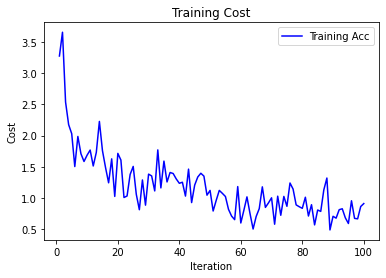

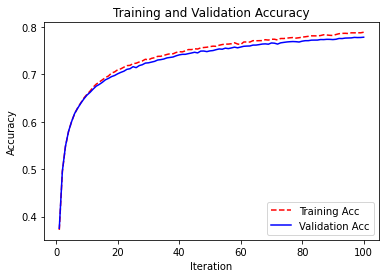

In [ ]:
plot_cost_history(train_history['loss'])
plot_acc_history(train_history['acc'], val_history['acc'])

Finally, let's check how the model generalizes for the test set.

In [ ]:
# Compute and display model accuracy on the test set
test_acc = (predict(X_test, theta, bias) == y_test).mean()
print(f'Test acc: {test_acc}')

Test acc: 0.7841



> **What are the conclusions? (1-2 paragraphs)**

As shown by the training cost per iteration graph, the convergece wasn't so smooth, which is due to the mini-batch approach. But it still converged and reached a reasonably good accuracy both for the training and the validation set, as pointed by the accuracy per iteration graph. This is a indication that the model didn't overfitted. The test accuracy confirm this hypothesis, as it's compatible with the training accuracy. 



For a simple model it performed really well, although there is clearly room for improvement. We know that with state of the art techniques it's possible to achieve a greater than $90\%$ accuracy on this problem. It would be interesting, therefore, to see how a more complex model performs, which will be done in the next section.



## **Activity 2**: Neural Network (6 points)

> **Move on to Neural Networks, using _one_ or _two hidden layers_. You should implement your solution (weight & bias initialization, forward propagation, backward propagation, activation function, ...).**


We chose to implement a neural network with one hidden layer. We'll explain the methods step by step and then wrap them in a class.

The first step is the initialization of parameters. Unlike in the regression algorithm, the gradient descent in neural networks is very sensitive to this step. As we'll use ReLU as an activation function, it's reasonable to apply the **He initialization**, which was proposed taking ReLU into account. It consists on multiplying the random initialization with $\sqrt{\frac{2}{\text{size}_{l-1}}}$, where $\text{size}_l$ represents the number of neurons at layer $l$.

[Click here](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78) for more details about weight initialization.

In [ ]:
def initialize_NN(input_size, hidden_size, output_size):
  """
  Method to initialize the neural network parameters (weights and biases).
  """

  params = {}

  # input -> hidden layer
  random_W1 = np.random.randn(input_size, hidden_size)
  params['W1'] = np.sqrt(2 / input_size) * random_W1
  params['b1'] = np.zeros((1, hidden_size))

  # hidden layer -> output
  random_W2 = np.random.randn(hidden_size, output_size)
  params['W2'] = np.sqrt(2 / hidden_size) * random_W2
  params['b2'] = np.zeros((1, output_size))

  return params

We already mentioned we'll use **ReLU** (rectified linear activation function) as the hidden layer activation function. ReLU was proposed to solve the vanishing gradient problem and it generally performs better than more traditional activation functions like sigmoid, besides being very simple. It's defined as $f(x) = \max(0, x)$.

In [ ]:
def ReLU(X):
  """
  Rectified linear activation function (ReLU).
  """

  return np.maximum(0,X)

For the output layer, the softmax function will be applied in the weighted output of the hidden layer and the cross entropy will be used to calculate the network cost, just like in activity 1. This (input $\rightarrow$ ReLU $\rightarrow$ softmax) represents the **forward pass** of the algorithm. We can also define a prediction method here, as in activity 1.

In [ ]:
def forward(X, y, params):
  """
  Neural network forward pass, which outputs probabilities of each sample being
  at each class and calculate the network loss, given the sample set and the 
  network parameters.
  """

  # input -> hidden layer (ReLU)
  h = ReLU(np.dot(X, params['W1']) + params['b1'])

  # hidden layer (ReLU) -> output (softmax)
  p, loss = cross_entropy_loss(np.dot(h, params['W2']) + params['b2'], y)

  return h, p, loss

def predict_NN(X, params):
  """
  Predicts in which class each sample in X is for given parameters and bias.
  """

  # input -> hidden layer (ReLU)
  h = ReLU(np.dot(X, params['W1']) + params['b1'])

  # hidden layer (ReLU) -> output (softmax)
  p = stable_softmax(np.dot(h, params['W2']) + params['b2'])

  return np.argmax(p, axis=1)
    

To update the parameters after the forward pass, it's necessary to calculate the cost derivative relative to each parameter. There are two main steps in the **backward pass**:

* For the **hidden layer $\rightarrow$ output layer** weights and biases, the gradient is computed as the dot product between the hidden layer output and the cross entropy derivative, being the same as the softmax regression gradient;
* To continue propagating for the **input layer $\rightarrow$ hidden layer** parameters we need to derivate ReLU, which is a non-differentiable function. By convention, we just assume that the ReLU derivative is $0$ if the input is less than or equal to $0$ and $1$ otherwise. The result is taken and multiplied by the network input to yield the gradient.

The gradient computation of a ReLU + softmax network similar to ours is explained in details [in this article](https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf).


In [ ]:
def backward(X, y, h, p, params):
  """
  Neural network backward pass, where the network gradients are calculated.
  """

  grads = {}

  # hidden layer -> output 
  dloss_z2 = cross_entropy_derivative(y, p)
  grads['W2'] = np.dot(h.T, dloss_z2)
  grads['b2'] = np.sum(dloss_z2, axis=0, keepdims=True)

  # input -> hidden layer
  dloss_z1 = np.dot(dloss_z2, params['W2'].T)
  dloss_z1[h <= 0] = 0 # ReLU derivative
  grads['W1'] = np.dot(X.T, dloss_z1)
  grads['b1'] = np.sum(dloss_z1, axis=0, keepdims=True)

  return grads

We'll now wrap these functions in a class and write the training method, where the gradient descent effectively happens. For now, ignore the hyperparameter `opt` and the local variable `s` inside `fit` (they are related to optimization and will be explained in the next activity). The other hyperparameters are the same as in softmax regression.



In [ ]:
class SimpleNN:
  """
  Simple neural network with one hidden layer activated by ReLU and output 
  activated by softmax.
  """

  def __init__(self, input_size, hidden_size, output_size):
    self.params = initialize_NN(input_size, hidden_size, output_size)

  def predict(self, X):
    return predict_NN(X, self.params)

  def forward(self, X, y):
    return forward(X, y, self.params)

  def backward(self, X, y, h, p):
    return backward(X, y, h, p, self.params)  

  def fit(self, X, y, initial_lr=1e-2, n_epochs=100, batch_size=100, opt=None):
    """
    Gradient descent method that updates the parameters of the neural network,
    fitting it to the training data.
    """

    self.train_history = {'acc': [], 'loss': []}
    self.val_history = {'acc': []}
    
    # Split training and validation set
    X_train, X_val = np.split(X, [int((2/3) * len(X))])
    y_train, y_val = np.split(y, [int((2/3) * len(y))])

    pbar = tqdm(range(n_epochs), position=0, unit='epoch')
    for epoch in pbar:

      # We shuffle X_train and y_train concatenated, to generate stable 
      # batches
      concat_data = pd.concat([X_train, y_train], axis=1)
      batches = get_batches(concat_data, batch_size)

      # Learning rates
      lr = {
        'W1': initial_lr, 
        'b1': initial_lr, 
        'W2': initial_lr, 
        'b2': initial_lr
      }

      # Used in optimization
      s = {'W1': 0, 'b1': 0, 'W2': 0, 'b2': 0}

      for (_, batch) in batches:

        # Detach X_train and y_train portions from batch
        X_batch = batch.drop(columns='label')
        y_batch = batch['label']

        # Feed forward to compute probability outputs and loss
        h, p, loss = self.forward(X_batch.values, y_batch.values)

        # Feed backward to compute the gradients
        self.grads = self.backward(X_batch.values, y_batch.values, h, p)

        if opt != None:
          # Optimization (adaptive learning rate)
          s, lr = opt(s, lr, initial_lr, self.grads)

        # Update weights and biases
        for name in ['W1', 'b1', 'W2', 'b2']:
          self.params[name] -= lr[name] * self.grads[name]
          
      # Calculate training and validation accuracies
      train_acc = (self.predict(X_train) == y_train).mean()
      val_acc = (self.predict(X_val) == y_val).mean()

      # Store loss and accuracies for future evaluation
      self.train_history['loss'].append(loss)
      self.train_history['acc'].append(train_acc)
      self.val_history['acc'].append(val_acc)

      # Show loss and accuracies at the progress bar
      pbar.set_postfix({
          'train_loss': round(loss, 2), 
          'train_acc': round(train_acc, 2), 
          'val_acc': round(val_acc, 2)
      })    

Let's fit the model to the training data with the default hyperparameters, i.e., `initial_lr=1e-2`, `n_epochs=100` and `batch_size=100`. We use the same hyperparameters we used in the softmax regression, to make a fair comparison later. The hidden layer contains $24$ neurons.

In [ ]:
nn = SimpleNN(X.shape[1], 24, len(labels))
nn.fit(X, y)

100%|██████████| 100/100 [02:17<00:00,  1.38s/epoch, train_loss=0.35, train_acc=0.88, val_acc=0.86]


With the trained model in hands, we can plot some graphics to see how it performed.

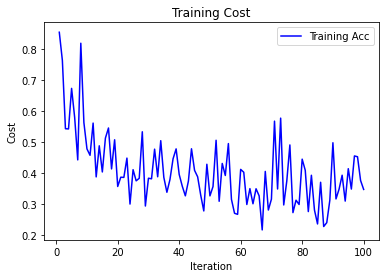

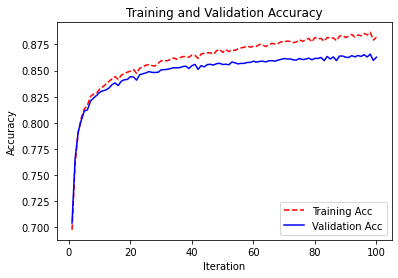

In [ ]:
plot_cost_history(nn.train_history['loss'])
plot_acc_history(nn.train_history['acc'], nn.val_history['acc'])

Finally, let's check how the model generalizes for the test set.

In [ ]:
# Compute and display model accuracy on the test set
test_acc = (nn.predict(X_test) == y_test).mean()
print(f'Test acc: {test_acc}')

Test acc: 0.8612


> **What are the conclusions? Regarding the Multinomial Logistic Regression model, does the performance improve? (2-4 paragraphs)**

The first thing that draws the attention at the cost per iteration graph is how unstable the convergence was, more so than in the softmax regression. Also, it took just a few epochs to the neural network converge to a higher than $80\%$ accuracy - after that, it still improves but fluctuates a lot.

Another thing to notice is that the accuracy per iteration graph starts to show signs of overfitting. Maybe if we trained for more epochs this would become a problem and we could easily stop the process earlier, but the training, validation and test accuracy were close enough at the end.

That said, it achieved a pretty good result overall, surpassing the multinomial regression test accuracy by nearly $8\%$. This shows that a more complex model like a neural network suits better than the simplest possible model for this classification task, even if it is a very simple neural network like ours.

## **Activity 3**: Optimization (1 point)

> **Apply two update rules used to optimize Neural Networks (for example, Momentum, Adagrad, Adam, RMSProp, Adadelta). For reference, see http://ruder.io/optimizing-gradient-descent.**


Even though we got a great result, the loss fluctuation can indicate that the fixed learning rate wasn't the best choice or that the gradient descent method got trapped at a suboptimal local minima. One way to avoid this is to adapt the learning rate to the dataset characteristics at execution time. In this activity, we'll apply the Adagrad and RMSProp update rules.

The idea behind **Adagrad** is to perform small updates for frequently occurring features and larger for infrequent ones, therefore being well-suited for dealing with sparse-data. Instead of using a constant $\alpha$ as the learning rate, we would use the vector:

\begin{align} 
\frac{\alpha}{\sqrt{s_i + \epsilon}}
\end{align}

where $s_i$ represents the sum of the square of the gradients up to iteration $i$ and $\epsilon$ is a small term that avoids division by zero. We'll now define the Adagrad update function, which will be sent to the neural network `fit` method as an argument.

In [ ]:
def adagrad(s, lr, initial_lr, grads):
  """
  Update the parameters learning rates with the Adagrad rule.
  """

  for name in ['W1', 'b1', 'W2', 'b2']:
    s[name] += grads[name]**2
    lr[name] = initial_lr / np.sqrt(s[name] + 1e-6)

  return s, lr

Let's fit the model to the training data with the default hyperparameters `initial_lr=1e-2` and `batch_size=100`. As we already know that the model without any optimization converges early and overfits at around $100$ epochs, we'll use `n_epochs=50` this time. The hidden layer contains $24$ neurons.

In [ ]:
nn_adagrad = SimpleNN(X.shape[1], 24, len(labels))
nn_adagrad.fit(X, y, n_epochs=50, opt=adagrad)

100%|██████████| 50/50 [01:11<00:00,  1.44s/epoch, train_loss=0.15, train_acc=0.92, val_acc=0.88]


With the trained model in hands, we can plot some graphics to see how it performed.

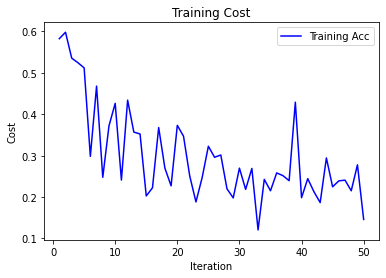

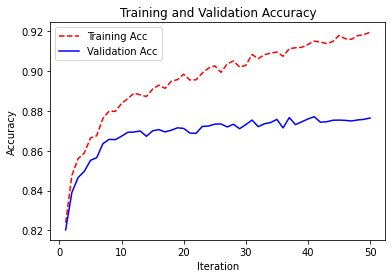

In [ ]:
plot_cost_history(nn_adagrad.train_history['loss'])
plot_acc_history(nn_adagrad.train_history['acc'], nn_adagrad.val_history['acc'])

Finally, let's check how the model generalizes for the test set.

In [ ]:
# Compute and display model accuracy on the test set
test_acc = (nn_adagrad.predict(X_test) == y_test).mean()
print(f'Test acc: {test_acc}')

Test acc: 0.8807


One possible problem associated with Adagrad is that the learning rate can radically decrease as it is updated. **RMSProp** was proposed to tackle that by giving a smaller weight to the sum of the square of the gradients. At RMSProp, $s_i$ is defined as $\gamma*s_{i-1} + (1-\gamma)*\Delta J^2$, where $0 \leq \gamma \leq 1$. We'll use $\gamma = 0.8$.

In [ ]:
def rmsprop(s, lr, initial_lr, grads):
  """
  Update the parameters learning rates with the RMSProp rule.
  """

  for name in ['W1', 'b1', 'W2', 'b2']:
    s[name] += 0.8*s[name] + 0.2*(grads[name]**2)
    lr[name] = initial_lr / np.sqrt(s[name] + 1e-6)

  return s, lr

Let's fit the model to the training data with the hyperparameters `initial_lr=1e-2`, `batch_size=100` and `n_epochs=50`, as with Adagrad. The hidden layer contains $24$ neurons.

In [ ]:
nn_rmsprop = SimpleNN(X.shape[1], 24, len(labels))
nn_rmsprop.fit(X, y, n_epochs=50, opt=rmsprop)

100%|██████████| 50/50 [01:12<00:00,  1.46s/epoch, train_loss=0.38, train_acc=0.83, val_acc=0.83]


With the trained model in hands, we can plot some graphics to see how it performed.

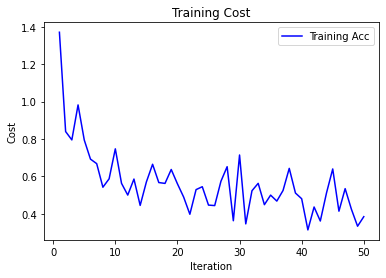

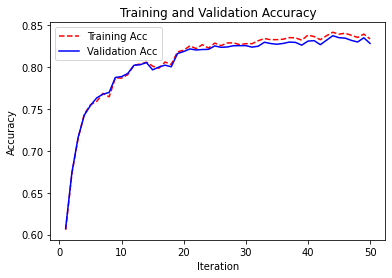

In [ ]:
plot_cost_history(nn_rmsprop.train_history['loss'])
plot_acc_history(nn_rmsprop.train_history['acc'], nn_rmsprop.val_history['acc'])

Finally, let's check how the model generalizes for the test set.

In [ ]:
# Compute and display model accuracy on the test set
test_acc = (nn_rmsprop.predict(X_test) == y_test).mean()
print(f'Test acc: {test_acc}')

Test acc: 0.828


 > **What are the conclusions? Does the performance improve? (1-2 paragraphs)**

As we trained for less epochs it's hard to compare the convergence with the non-optimized neural network, but it's clear that the fluctuation problem wasn't solved with Adagrad. Also, it converged really fast and overfitted even more. Even so, the test accuracy obtained ($88\%$) is better than in the standard approach ($86\%$).

On the other hand, the RMSProp curves are a lot smoother when compared to the others neural networks, which can be due to the slower convergence. The test accuracy ($83\%$) worsened even in relation to the non-optimized model - as Adagrad already worked well, maybe changing the adaptive learning rate denominator is not necessary for this problem. 


## **Activity 4**: Confusion Matrix (1 point)

> **Pick your best model and plot the confusion matrix in the test set. You can use scikit-learn libraries.**

As observed at activity 3, our best model in terms of results is the Neural Network improved with the Adagrad optimization technique, so we'll analyze the confusion matrix for this model here.

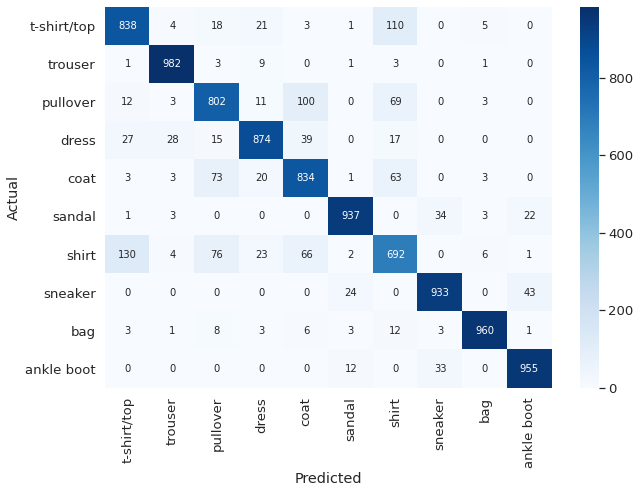

In [ ]:
# Build confusion matrix with scikit learn
cmatrix = confusion_matrix(y_test, nn_adagrad.predict(X_test))

# Save it as a pandas dataframe
df_cm = pd.DataFrame(cmatrix, columns=labels, index=labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# Plot as a seaborn heatmap
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 10}, fmt='g');

> **What are the conclusions? (1-2 paragraphs)**

In this matrix, the main diagonal reveals the correct guesses (true positives). Pick a element from the diagonal and it's label. It's horizontal represents the images that the model predicted to be from another label but were from this label (false negatives) and it's vertical the images that the model predicted to be from this label but were from another (false positives). The per-label mistake percentual is small, varying between $2\%$ and $10\%$ approximately.

If we pay attention to the t-shirt/top, pullover and shirt rows we notice that these are the ones with most errors and that the model misled these garments with a high frequency, compared with other labels. That's comprehensible, since they are very alike. It is nice to see, though, that in general there was just a few mistakes. Indeed, looking at the confusion matrix, we can confirm that this model worked as expected.